# Exercise 1: Introduction to pyiron

## Imports and and working with projects

In [1]:
import numpy as np
import matplotlib.pylab as plt

In [2]:
from pyiron import Project

In [3]:
pr = Project("demo")
pr.remove_jobs()

In [4]:
pr.path

'/home/surendralal/notebooks/pyiron-virtual-workshop-2020/tutorials/day_1/demo/'

In [5]:
pr.job_table()

""


## Creating and manipulating structures

In [7]:
# atomistic structures
Al_struct = pr.create_ase_bulk("Al", cubic=True).repeat([2, 2, 4])
Al_struct.plot3d()

_ColormakerRegistry()

NGLWidget()

In [8]:
Al_struct[36] = "Cu"
Al_struct.plot3d()

NGLWidget()

In [9]:
del Al_struct[34]
Al_struct.plot3d()

NGLWidget()

### Creating a water of water molecules

In [41]:
cell = np.eye(3) * 10
r_O = [0, 0, 0]
r_H1 = [0.0, 0.7, 0.7]
r_H2 = [0.0, 0.7, -0.7]
water_molecule = pr.create_atoms("H2O", positions=[r_H1, r_H2, r_O], cell=cell)
water_molecule.center()
water_molecule.set_cell(water_molecule.cell * water_molecule.get_density() ** (1/3), scale_atoms=False)
water_molecule.get_density()
water_box = water_molecule.repeat(3)
water_box.center_coordinates_in_unit_cell()
water_box.plot3d()

NGLWidget()

### Creating an Al supercell with interstitial H

In [11]:
Al_struct = pr.create_ase_bulk("Al", cubic=True)
H_int = Al_struct.copy()
H_int[:] = "H"
H_int.scaled_positions += 0.5
Al_struct.set_repeat([2, 2, 4])
H_int.set_repeat([2, 2, 4])
rand_int = np.arange(0, len(H_int))
np.random.shuffle(rand_int)
AlH_struct = Al_struct + H_int[rand_int[:10]]
AlH_struct.plot3d()

NGLWidget()

## Setting up and running LAMMPS calculations

In [12]:
job_lammps = pr.create_job(job_type=pr.job_type.Lammps, job_name= "AlH_lammps")
job_lammps.structure = AlH_struct
print(job_lammps.list_potentials())
job_lammps.potential =  'Al_H_Ni_Angelo_eam'
job_lammps.calc_md(temperature=600, n_ionic_steps=10000)

['Al_H_Ni_Angelo_eam', '1995--Angelo-J-E--Ni-Al-H--LAMMPS--ipr1', '2018--Zhou-X-W--Al-Cu-H--LAMMPS--ipr1', 'EAM_Dynamo_AngeloMoodyBaskes_1995_NiAlH__MO_418978237058_005']


In [13]:
job_lammps.run()

The job AlH_lammps was saved and received the ID: 8
The files are already compressed!


In [14]:
H_indices = AlH_struct.select_index("H")
Al_indices = AlH_struct.select_index("Al")
H_indices

array([64, 65, 66, 67, 68, 69, 70, 71, 72, 73])

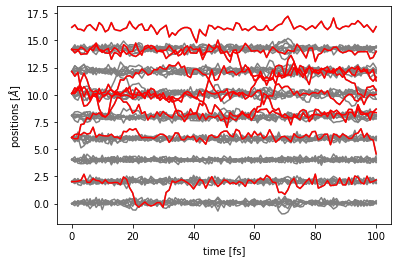

In [17]:
plt.plot(job_lammps.output.unwrapped_positions[:, :, 2], color="grey")
plt.plot(job_lammps.output.unwrapped_positions[:, H_indices, 2], color="red")
plt.xlabel("time [fs]")
plt.ylabel("positions [$\AA$]");

In [18]:
md_struct = job_lammps.get_structure(iteration_step=-1)

In [19]:
md_struct.plot3d()

NGLWidget()

In [20]:
job_lammps_minimize = pr.create_job(pr.job_type.Lammps, "AlH_minimize")
job_lammps_minimize.structure = md_struct

In [21]:
job_lammps_minimize.potential = job_lammps.potential.copy()

In [22]:
job_lammps_minimize.calc_minimize(pressure=0)

In [23]:
job_lammps_minimize.run()

The job AlH_minimize was saved and received the ID: 9
The files are already compressed!


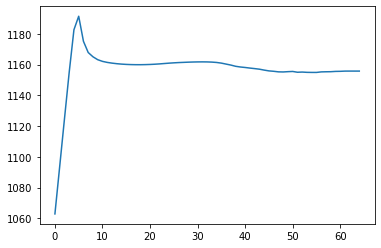

In [24]:
plt.plot(job_lammps_minimize.output.volume)

In [25]:
job_lammps_minimize.animate_structure()

NGLWidget(max_frame=64)

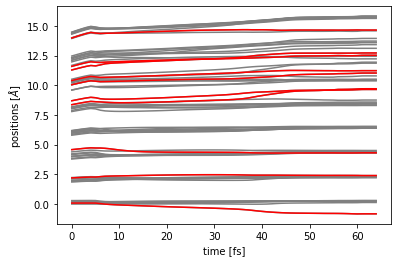

In [28]:
plt.plot(job_lammps_minimize.output.unwrapped_positions[:, :, 2], color="grey")
plt.plot(job_lammps_minimize.output.unwrapped_positions[:, H_indices, 2], color="red")
plt.xlabel("time [fs]")
plt.ylabel("positions [$\AA$]");

## Analysis

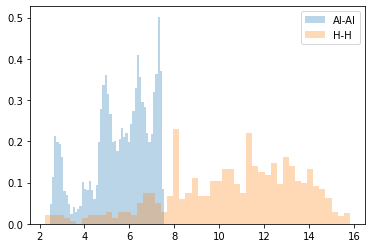

In [29]:
neighbors_md = md_struct[Al_indices].get_neighbors(num_neighbors=100)
plt.hist(neighbors_md.distances.flatten(), bins=50, alpha=0.3, density=True, label="Al-Al")
neighbors_md = md_struct[H_indices].get_neighbors(num_neighbors=100)
plt.hist(neighbors_md.distances.flatten(), bins=50, alpha=0.3, density=True, label="H-H")
plt.legend();

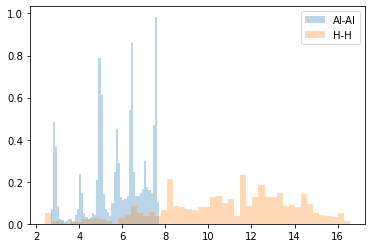

In [30]:
min_struct = job_lammps_minimize.get_structure(-1)
neighbors_min = min_struct[Al_indices].get_neighbors(num_neighbors=100)
plt.hist(neighbors_min.distances.flatten(), bins=50, alpha=0.3, density=True, label="Al-Al")
neighbors_min = min_struct[H_indices].get_neighbors(num_neighbors=100)
plt.hist(neighbors_min.distances.flatten(), bins=50, alpha=0.3, density=True, label="H-H")
plt.legend();

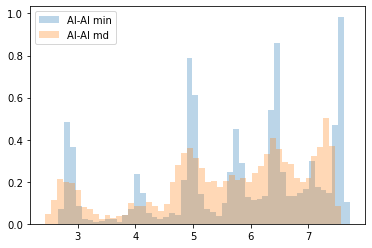

In [31]:
neighbors_min = min_struct[Al_indices].get_neighbors(num_neighbors=100)
plt.hist(neighbors_min.distances.flatten(), bins=50, alpha=0.3, density=True, label="Al-Al min")
neighbors_md = md_struct[Al_indices].get_neighbors(num_neighbors=100)
plt.hist(neighbors_md.distances.flatten(), bins=50, alpha=0.3, density=True, label="Al-Al md")
plt.legend();

In [32]:
pr.job_table()

,id,status,chemicalformula,job,subjob,projectpath,project,timestart,timestop,totalcputime,computer,hamilton,hamversion,parentid,masterid
0,8,finished,Al64H10,AlH_lammps,/AlH_lammps,/home/surendralal/,notebooks/pyiron-virtual-workshop-2020/tutorials/day_1/demo/,2020-04-11 01:58:04.838009,2020-04-11 01:58:10.237959,5.0,pyiron@cmdell17#1,Lammps,0.1,None,None
1,9,finished,Al64H10,AlH_minimize,/AlH_minimize,/home/surendralal/,notebooks/pyiron-virtual-workshop-2020/tutorials/day_1/demo/,2020-04-11 01:58:35.063075,2020-04-11 01:58:37.686034,2.0,pyiron@cmdell17#1,Lammps,0.1,None,None


In [33]:
job_md_reloaded = pr.load("AlH_lammps")

In [34]:
job_min_reloaded = pr.load("AlH_minimize")

In [35]:
job_min_reloaded

{'groups': ['input', 'output'], 'nodes': ['NAME', 'TYPE', 'VERSION', 'server', 'status']}

In [36]:
pr

{'groups': [], 'nodes': ['AlH_lammps', 'AlH_minimize']}

In [37]:
pr["AlH_lammps"]

{'groups': ['input', 'output'], 'nodes': ['NAME', 'TYPE', 'VERSION', 'server', 'status']}

In [38]:
pr["AlH_lammps/input"]

{'groups': ['control_inp', 'generic', 'potential', 'potential_inp', 'structure'], 'nodes': ['generic_dict', 'interactive']}

In [39]:
pr["AlH_lammps/output/generic/forces"].shape,  pr["AlH_lammps/output/generic/energy_tot"].shape

((101, 74, 3), (101,))

## Murnaghan using LAMMPS

Hint: use for loops and calc_minimize